In [1]:
import pandas as pd
import random
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet import preprocess_input as process_mobilenet
from tensorflow.keras.applications.resnet50 import preprocess_input as process_resnet
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as process_vgg
import itertools

import cv2

from sklearn.metrics import confusion_matrix, accuracy_score
# Start CoLab
try:
  from google.colab import drive
  %tensorflow_version 2.x
  drive.mount('/content/drive', force_remount=True)
  COLAB = True
  print("Note: using Google CoLab")
except:
  print("Note: not using Google CoLab")
  COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [3]:
def wrap_generator(generator):
    while True:
        x,y = next(generator)
        y = tf.keras.utils.to_categorical(y)
        zeros = tf.zeros_like(y) + tf.constant([1.,0.])
        y = tf.concat([y,zeros], axis=0)
        yield x,y

In [4]:
def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)



In [5]:
def get_model(train=True):
    set_seed(33)
    inp = Input((224,224,3))


    mobilenet = MobileNet(weights = 'imagenet', include_top = False)
    resnet = ResNet50(weights = 'imagenet', include_top = False)

    for layer in mobilenet.layers[:-4]:
        layer.trainable = False

    for layer in resnet.layers[:-4]:
        layer.trainable = False

    pre_1 = Lambda(process_mobilenet)
    mobilenet_process = pre_1(GaussianNoise(0.1)(inp))
    mobile_net = mobilenet(mobilenet_process)

    noise = Lambda(tf.zeros_like)(mobile_net)
    noise = GaussianNoise(0.1)(noise)

    if train:
        x = Lambda(lambda z: tf.concat(z, axis=0))([mobile_net,noise])
        x = Activation('relu')(x)
    else:
        x = mobile_net

    x_mobilenet = GlobalMaxPool2D()(x)
    x_mobilenet = Dense(1024, activation='relu')(x_mobilenet)

    pre_2 = Lambda(process_resnet)
    resnet_process = pre_2(GaussianNoise(0.1)(inp))
    res_net = resnet(resnet_process)

    noise = Lambda(tf.zeros_like)(res_net)
    noise = GaussianNoise(0.1)(noise)

    if train:
        w = Lambda(lambda z: tf.concat(z, axis=0))([res_net ,noise])
        w = Activation('relu')(w)
    else:
        w = res_net 
  
    x_resnet = GlobalMaxPool2D()(w)
    x_resnet = Dense(1024, activation='relu')(x_resnet)


    a = Average()([x_mobilenet, x_resnet])
        
    a = Dense(512, activation='relu')(a)
    a = Dense(128, activation='relu')(a)
    out = Dense(2, activation='softmax')(a)
 
    model = Model(inp, out)
    model.compile(Adam(lr=1e-3), loss='binary_crossentropy')
    
    return model

In [6]:

### CREATE EMPTY GENERATORS ###

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

SHAPE = (224,224,3)

In [7]:
### FLOW GENERATORS ###

train_generator = train_datagen.flow_from_directory(
            '/content/drive/My Drive/Dataset_Project/Dataset 4',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = 256,
            class_mode = 'categorical',
            shuffle = True,
            seed = 33,
            classes = ['no']
    )

test_generator = test_datagen.flow_from_directory(
            '/content/drive/My Drive/Dataset_Project/Dataset 2/',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = 256,
            class_mode = 'categorical',
            shuffle = False,
            seed = 33,
            classes = ['no','yes']
)

Found 1500 images belonging to 1 classes.
Found 253 images belonging to 2 classes.


In [8]:
print(train_generator.class_indices)
print(test_generator.class_indices)

{'no': 0}
{'no': 0, 'yes': 1}


In [9]:
# es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=5)

model = get_model()
model.fit(wrap_generator(train_generator), steps_per_epoch=train_generator.samples/train_generator.batch_size, epochs=5)

94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/5
5/5 [==============================] - 316s 53s/step - loss: 1.1756
Epoch 2/5
5/5 [==============================] - 302s 52s/step - loss: 0.9616
Epoch 3/5
5/5 [==============================] - 305s 52s/step - loss: 0.8537
Epoch 4/5
5/5 [==============================] - 302s 51s/step - loss: 0.6498
Epoch 5/5
5/5 [==============================] - 309s 53s/step - loss: 0.2375


In [10]:
  ### RETRIVE TEST LABEL FROM GENERATOR ###

test_num = test_generator.samples

label_test = []
for i in range((test_num // test_generator.batch_size)+1):
    X,y = test_generator.next()
    label_test.append(y)
        
label_test = np.argmax(np.vstack(label_test), axis=1)
label_test.shape
print(label_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [11]:
### SWITCH TO INFERENCE MODE TO COMPUTE PREDICTIONS ###

ineference_model = get_model(train=False)
# ineference_model.set_weights(model.get_weights())

In [12]:
### COMPUTE PREDICTIONS ON TEST DATA ###

pred_test = np.argmax(ineference_model.predict(test_generator), axis=1)
print(pred_test)

[1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0
 0 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1
 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 0
 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 0
 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 1 1 0 0 0 0 0 1 0 1 1 0 1
 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0
 1 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1]


In [13]:

### ACCURACY ON TEST DATA ###

print('ACCURACY:', accuracy_score(label_test, pred_test))

ACCURACY: 0.5849802371541502


In [1]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

NameError: ignored

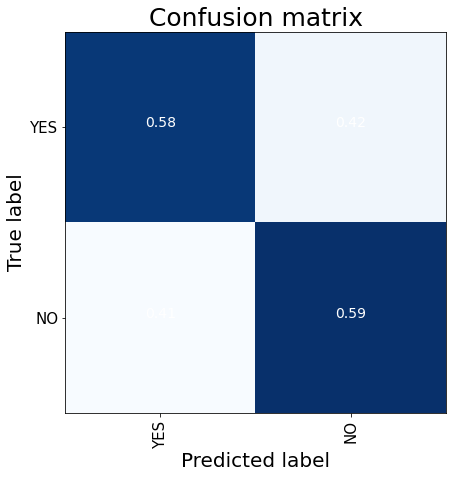

In [15]:
### CONFUSION MATRIX ON TEST DATA ###

cnf_matrix = confusion_matrix(label_test, pred_test)

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=['YES','NO'])
plt.show()

In [ ]:
from sklearn .metrics import roc_auc_score 
from sklearn import metrics
print(roc_auc_score(label_test,pred_test))

0.5843647136273864
